# Comparing Speech Analytics Models

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import random as rd
from adaptors import youtube2df, aws2df

## Loading csv files

In [2]:
# load the real file
df_real = pd.read_csv('real.csv', names=['file', 'transcript'])
# load the model file
df_model = pd.read_csv('no_ipa.csv', names=['file', 'transcript'])


## Comparing Two lines

In [2]:
# function that neutralizes the string
def neutralize(a_string):
    return a_string.lower()

# function that calculates percentage of similarity
def similarity_score(string_real, string_model, extra_info=False):

    # cut strings to bag of words
    words_real = neutralize(string_real).split(' ')
    count = 0
    error_words = []
    for word in words_real:
        # search word in string_model
        if word in neutralize(string_model):
            count = count + 1
        else:
            error_words.append(word)

    score = count / len(words_real)
    if extra_info:
        return score, error_words

    return score

In [4]:
scr, failed_words = similarity_score(df_real['transcript'][0], df_model['transcript'][0],
                                     extra_info=True)
print(scr)
print(failed_words)

0.8
['alo', 'tardes?', 'hablo', 'perez', 'conversacion', 'socofin', 'credichile', 'inpago', 'credito', 'dosmil', 'veinte,', 'cancelo', 'dia']


## Comparing two dataframes
To compare two dataframes we can use the function we just made but taking care that we
use the correct file from each row.

In [5]:
def similarity_score_dataframes(_df_real, _df_model):
    score_list = []

    for _a_file, a_string in zip(_df_model['file'], _df_model['transcript']):
        # first, we search for file in real
        real_str = _df_real[_df_real['file']==_a_file]['transcript']

        # files should be 1:1, if not, we riot
        if len(real_str) != 1:
            AttributeError('Dude files are not 1:1 in ' + _a_file)

        # otherwise let's continue calculating the score
        print(real_str.array)
        score, fails = similarity_score(real_str.array[0], a_string, extra_info=True)
        score_list.append((_a_file, score, fails))

    return pd.DataFrame(score_list, columns=['file', 'score', 'failed_words'])

In [6]:
scr_list = similarity_score_dataframes(df_real, df_model)
scr_list.head()


<PandasArray>
['alo buenas tardes? hablo con don manuel perez rojo si don manuel habla con su ejecutiva virtual para su seguridad esta conversacion podría ser grabada lo estamos llamando de Socofin por encargo de Banco CrediChile para informarle que se encuentra inpago su credito de consumo con fecha cinco de noviembre de dosmil veinte, si usted ya cancelo favor omitir este mensaje que tenga buen dia']
Length: 1, dtype: object
<PandasArray>
['alo buenas tardes? hablo con don manuel perez rojo si don manuel habla con su ejecutiva virtual para su seguridad esta conversacion podría ser grabada lo estamos llamando de Socofin por encargo de Banco CrediChile para informarle que se encuentra inpago su credito de consumo con fecha cinco de noviembre de dosmil veinte, si usted ya cancelo favor omitir este mensaje que tenga buen dia']
Length: 1, dtype: object


,file,score,failed_words
0,100884402_995867770_100179896630201118_2020111...,0.8,"[alo, tardes?, hablo, perez, conversacion, soc..."
1,100884402_995867770_100179896630201118_2020111...,0.8,"[alo, tardes?, hablo, perez, conversacion, soc..."


## Example plot for model comparison
We use seaborn box-plots to check performance between two models.

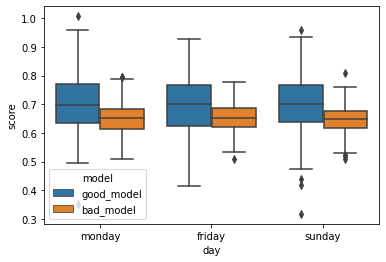

In [7]:
# we simulate to score lists
N = 1000
days = ['monday', 'friday', 'sunday']
good_model = [rd.gauss(0.7, 0.1) for i in range(N)]
bad_model = [rd.gauss(0.65, 0.05) for j in range(N)]

# transform my two lists in a dataframe
good_tuples = [('good_model', a_score, days[index%3]) for index, a_score in enumerate(good_model)]
bad_tuples = [('bad_model', a_score, days[index%3]) for index, a_score in enumerate(bad_model)]

df = pd.DataFrame(good_tuples + bad_tuples, columns=['model', 'score', 'day'])

sb.boxplot(data=df, x='day', y='score', hue='model')
plt.show()

## Transform Youtube caps and AWS
We need to create an internal function to translate from one file to another easily, to do this, we
transform both files to a dataframe with fields in common.

In [7]:
frame = youtube2df('./EdoCaroe/video_0_es-419.txt')
frame.head()


,orig_index,start,end,transcript
0,1,103.916,107.333,"¡Me ha traído puros problemas este lugar, weón!"
1,2,110.083,111.375,"<b>Me voy a electrocutar ahora, culiao.</b>"
2,3,111.375,113.541,"<b>Te apuesto, eso va a pasar.</b>"
3,4,114.916,116.833,"<b>Tomás, culiao, también.</b>"
4,5,126.916,128.416,"<b>Ay, weón...</b>"


In [8]:
frame = aws2df('video_0.json')
frame.head()

,start,end,transcript
0,0.04,0.51,La
1,0.51,1.03,Fallida
2,1.03,1.73,actuaciÃ³n
3,1.74,1.92,en
4,1.92,3.08,Rancagua


In [9]:
# Debugging adaptor function
frame_test = youtube2df('test.txt')
frame_test.head()

,orig_index,start,end,transcript
0,2,3.27,6.870,problema de este lugar web sin duda uno
1,3,5.43,9.090,de los shows mÃ¡s raros de la gira moto
2,4,6.87,15.990,al sur y probablemente uno de los
3,5,9.09,18.150,mejores pero bueno los shows de la gira
4,6,15.99,21.119,en moto no se hacen en grandes teatros


In [27]:
# Create a concatenation of text for each time interval in validation data
# IMPORTANT: We assume words are in order!

# load validation
valid = youtube2df('./EdoCaroe/video_0_es-419.txt')

# load model output
predicted = aws2df('video_0.json').astype({'start':'float', 'end':'float', 'transcript':'string'})

# both dfs must have start and end times in same format and concatenated field
def compress(df_reference, df_to_modify, field='transcript'):

    container = []

    # for each interval we find a sub-df with all the content
    for start, end in zip(df_reference['start'], df_reference['end']):
        # sub-df
        sub_df = df_to_modify[(df_to_modify['start'] >= start) & (df_to_modify['end'] <= end)]

        # now concatenate every word
        words = [a_word for a_word in sub_df[field]]

        container.append(' '.join(word for word in words))

    return container

valid['aws_transcript'] = compress(valid, predicted)
valid.head(10)


,orig_index,start,end,transcript,aws_transcript
0,1,103.916,107.333,"¡Me ha traído puros problemas este lugar, weón!",lo puro problema este lugar Bueno lo puro prob...
1,2,110.083,111.375,"<b>Me voy a electrocutar ahora, culiao.</b>",voy a tributar ahora Cuidado voy a tributar ah...
2,3,111.375,113.541,"<b>Te apuesto, eso va a pasar.</b>",puedes Todo esto va a pasar puedes Todo esto v...
3,4,114.916,116.833,"<b>Tomás, culiao, también.</b>",Toma Julia Toma Julia
4,5,126.916,128.416,"<b>Ay, weón...</b>",Hay Hay
5,6,130.916,132.833,<b>Ya seguimos.</b>,Seguimos Seguimos
6,7,133.333,136.458,"<b>Ya, tirar agua a donde sea.</b>",tirar agua tirar agua
7,8,140.208,141.916,<b>Tirar agua.</b>,agua agua
8,9,144.333,146.916,<b>Qué weá estaba diciendo antes de esta…</b>,Bueno estaba diciendo antes de todo Bueno esta...
9,10,147.083,149.208,<b>Pero mira esta weá.</b>,te voy a te voy a
